In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')

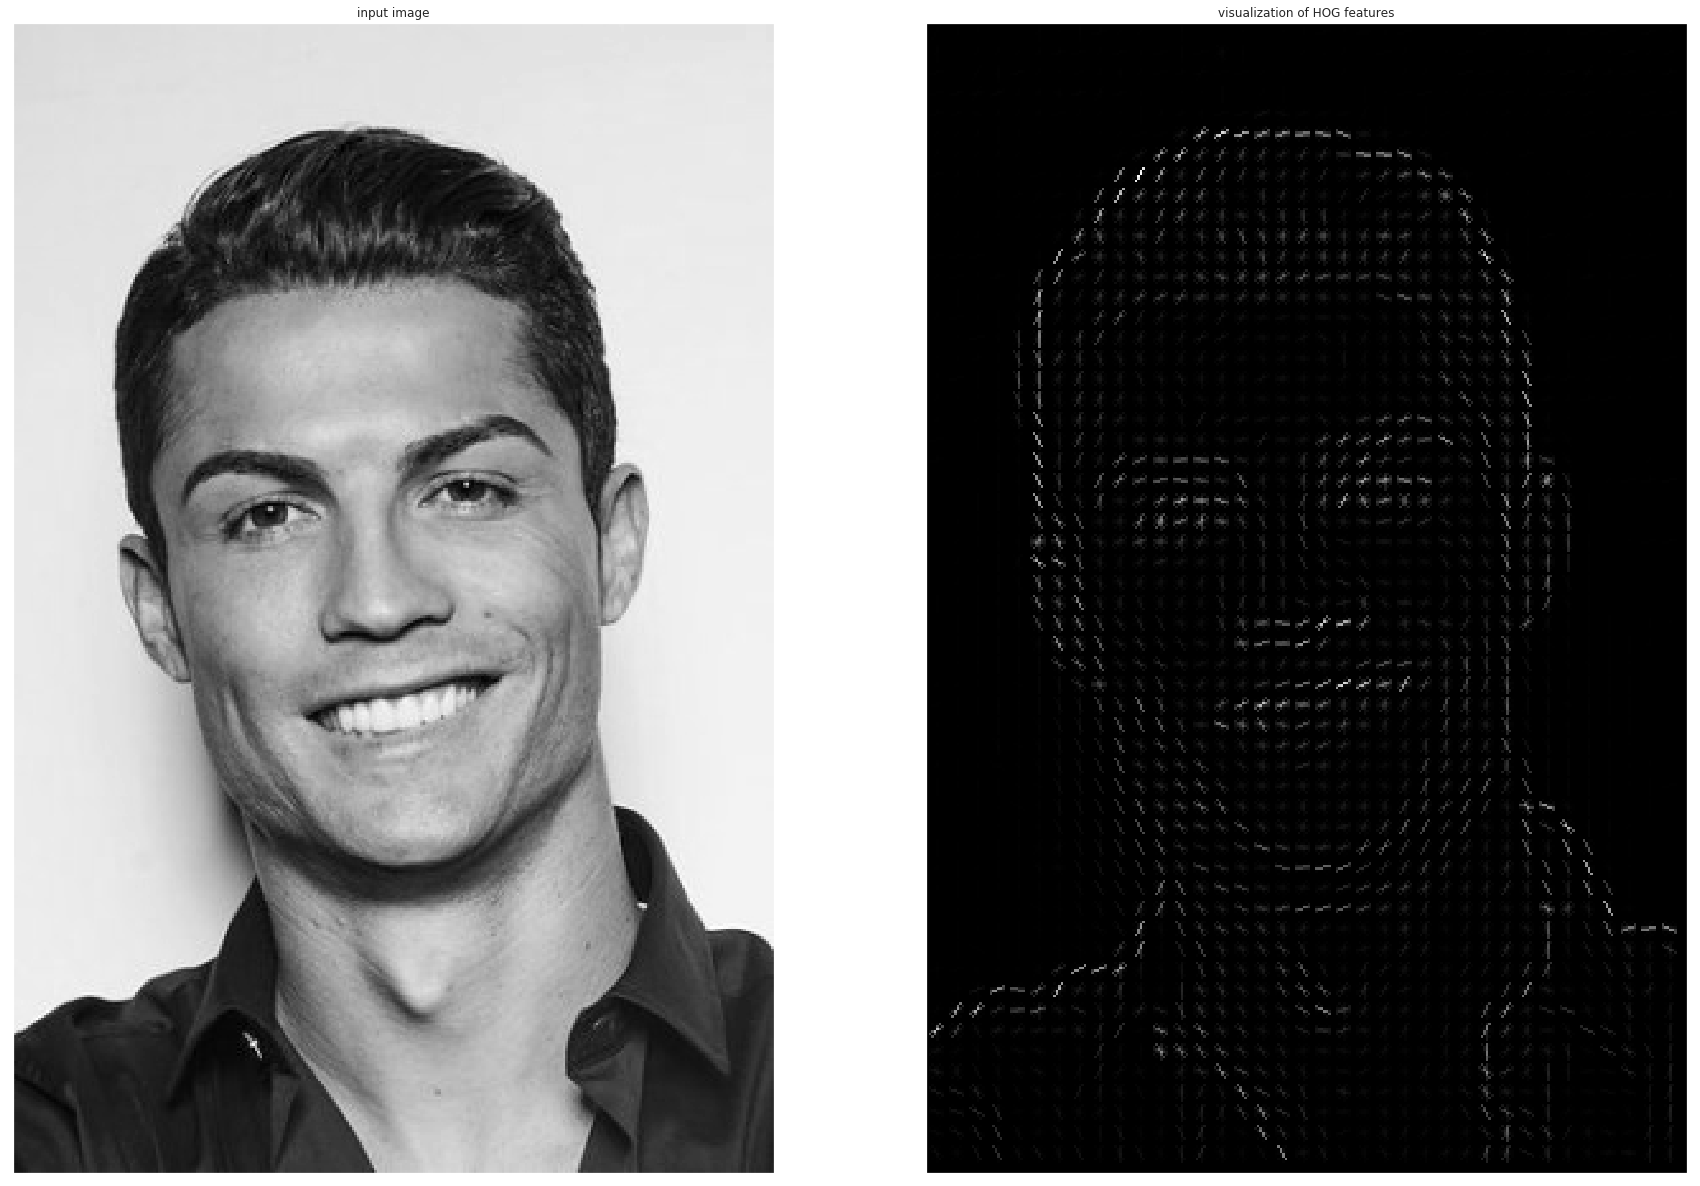

In [11]:
from skimage import data, color, feature
import skimage.data
img=cv2.imread("face-structure.jpg")
# image = color.rgb2gray(data.chelsea())
image = color.rgb2gray(img)
hog_vec, hog_vis = feature.hog(image, visualise=True)
fig, ax = plt.subplots(1, 2, figsize=(30, 30),subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis,cmap='gray')
ax[1].set_title('visualization of HOG features');

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [17]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())for name in imgs_to_use]

In [18]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

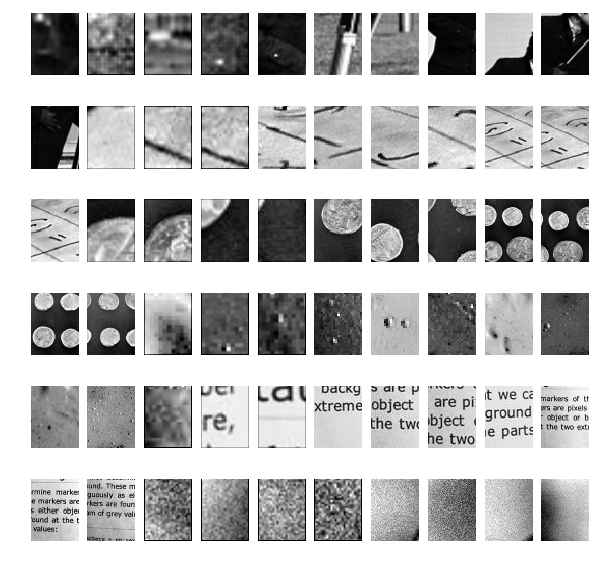

In [19]:
fig, ax = plt.subplots(6, 10,figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[290 * i], cmap='gray')
    axi.axis('off')

In [20]:
from itertools import chain
X_train = np.array([feature.hog(im) for im in chain(positive_patches,negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [21]:
X_train.shape

(43233, 1215)

In [22]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.cross_validation import cross_val_score
# cross_val_score(GaussianNB(), X_train, y_train)

In [23]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            

In [24]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9864224088080864

In [25]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [26]:
def predict(path):
    test_image = cv2.imread(path)
    test_image = skimage.color.rgb2gray(test_image)
    test_image = skimage.transform.rescale(test_image, 0.5)
    # test_image = test_image[:160, 40:180]
    plt.imshow(test_image, cmap='gray')
    plt.axis('off');
    indices, patches = zip(*sliding_window(test_image))
    patches_hog = np.array([feature.hog(patch) for patch in patches])
#     patches_hog.shape
    labels = model.predict(patches_hog)
#     labels.sum()
    fig, ax = plt.subplots()
    ax.imshow(test_image, cmap='gray')
    ax.axis('off')
    
    Ni, Nj = positive_patches[0].shape
    indices = np.array(indices)

    for i, j in indices[labels == 1]:
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.2, lw=1, facecolor='none'))
    

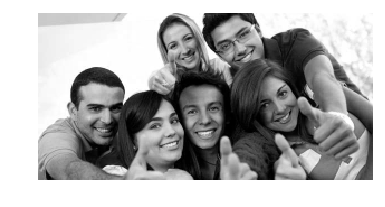

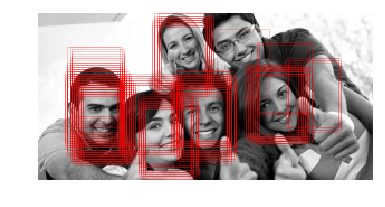

In [28]:
predict("group-booking.jpg")